In [1]:
import pandas as pd
import numpy as np
import re
import os.path
import io
from bs4 import BeautifulSoup

In [2]:
text_files = '/Users/home/LiberatingArchives/corpus'

In [3]:
all_text = []
for file in os.listdir(text_files):
    if file != '.DS_Store':
        all_text.append(os.path.join(text_files, file))

In [4]:
# Global Lists for all Texts
all_titles = []
all_dates = []
all_post_id = []
all_locations = []
all_categories = [] # list within list
all_entry_content = []

# Global Lists for Legislation Texts
bill_number = [] # i.e. AB ###
bill_author = []
bill_party = []
bill_post_id = []
bill_title = []
bill_veto = [] # True = Veto
bill_pdf_link = []

# Global Lists for Appointments
app_post_id = []
app_dates = []
app_name = []
app_gender = []
app_party = []
app_full_descr = []
app_entry_content = []

In [5]:
cats = set()

In [6]:
for textFile in all_text: # Change to length of list
    with open(textFile, "r") as f:
        curr_text = f.read()
    #
    all_titles.append(re.findall("""<h1 class=\"[^\"]+\".*?>(.+?)<\/h1>""", curr_text)[0])
    try:
        date = re.findall("""Published: <time datetime=\"(.*?)\"""", curr_text)[0]
    except IndexError:
        date = np.nan # Date not specified in text file. There is 1 occurrence.
    
    all_dates.append(date)
        
    post_id = re.findall("""<article id=\"post-([\d]+)\"""", curr_text)[0]
    categories = re.findall("""category-([\w-]+)""", curr_text)
    
    all_post_id.append(int(post_id))
    all_categories.append(categories)
    
    cats.update(categories)
    
    curr1_text = re.findall("""<div class=\"entry-content\">([\s\S]+?)<!-- .et_pb_post -->""", curr_text)
    souped = BeautifulSoup(curr1_text[0], 'html.parser')
    text_parsed = souped.get_text()
    
    all_entry_content.append(text_parsed)
    
    try:
        all_locations.append(re.findall('([A-Z][A-Z| ]+)', text_parsed)[0])
    except IndexError:
        all_locations.append(np.nan)
    
    
    #
    if 'appointments' in categories:
        apps = [app for app in re.split('\n', text_parsed) if not app.isspace() and app != '' and app != '###'][1:]
        
        prev = -1
        for app in apps:
            flag = True
            #print(app)
            
            try:
                name = re.findall('^(?:[•|–]\t)?(?:– )?(.+?),', app)[0] 
                app_name.append(name)
                if 'compensation' in name:
                    
                    app_full_descr[prev] = app_full_descr[prev] + ' ' + name
                    flag = False
                    
            except IndexError:
                if flag:
                    app_name.append('')
            
            if True:
                app_post_id.append(int(post_id))
                app_dates.append(date)
                
                if 'She ' in app or ' she ' in app or 'female' in app or 'lesbian' in app:
                    app_gender.append('F')
                elif 'He ' in app or ' he ' in app:
                    app_gender.append('M')
                else:
                    app_gender.append(np.nan)
            
                try:
                    app_party.append(re.findall('Democrat|Republican', app)[0])
                    
                except IndexError:
                    app_party.append(np.nan)
                
                app_full_descr.append(app)
            
                app_entry_content.append(text_parsed)
           
   # elif 'legislation' in categories:
    #    bill_split_veto = souped_bill_entry_content_no_html.split("vetoed")
     #   bills_regex = """(\w+?\s\d+?) by ([\s\S]+?)( | \(([\w\s-]+?)\) )(–|which) ([\s\S]+?)(\.|\n)"""
      #  bills_passed = re.findall(bills_regex, bill_split_veto[0])
       # bills_vetoed = []
       # if len(bill_split_veto) == 2:
        #    bills_vetoed = re.findall(bills_regex, bill_split_veto[1])


In [7]:
#all_titles = []
#all_dates = []
#all_post_id = []
#all_locations = []
#all_categories = []  list within list
#all_entry_content = []

In [8]:
#app_post_id = []
#app_name = []
#app_role = []
#app_party = []

In [9]:
apps_tbl = pd.DataFrame()
apps_tbl['post_id'] = app_post_id
apps_tbl['date'] = app_dates
apps_tbl['date'] = pd.to_datetime(apps_tbl['date'])

apps_tbl['name'] = app_name
apps_tbl['gender'] = app_gender
apps_tbl['party'] = app_party
apps_tbl['description'] = app_full_descr
#apps_tbl['full'] = app_entry_content

In [10]:
apps_tbl['name'] = apps_tbl['name'].apply(lambda x: np.nan if 'compensation' in x or x == '' else x)

In [11]:
apps_tbl.dropna(subset = ['name'], inplace = True)

In [12]:
apps_tbl = apps_tbl[~apps_tbl.name.str.contains("""^“.""")]
apps_tbl = apps_tbl[~apps_tbl.name.str.contains("\d")]
apps_tbl = apps_tbl[~apps_tbl.name.str.contains("NOTE")]
apps_tbl = apps_tbl[~apps_tbl.name.str.contains(",")]
apps_tbl = apps_tbl[~apps_tbl.name.str.contains("Commanding")]
apps_tbl['name'] = apps_tbl['name'].str.replace('^ ', '')
apps_tbl = apps_tbl[(~apps_tbl.name.str.contains(" [a-z]")) & (~apps_tbl.name.str.contains(" de")) & 
                 (~apps_tbl.name.str.contains(" van ")) & (~apps_tbl.name.str.contains(" von "))]
apps_tbl = apps_tbl.drop_duplicates(subset = ['name', 'date']) #3 duplicates
apps_tbl = apps_tbl.sort_values('post_id').reset_index(drop = True)

In [13]:
apps_tbl.head()

,post_id,date,name,gender,party,description
0,652,2011-01-05,Marty Morgenstern,M,Democrat,"Marty Morgenstern, of Oakland, has been appoin..."
1,652,2011-01-05,Mary Nichols,F,Democrat,"Mary Nichols, of Los Angeles, has been reappoi..."
2,652,2011-01-05,Ronald Yank,M,Democrat,"Ronald Yank, of Oakland, has been appointed Di..."
3,652,2011-01-05,Dr. Carl Anthony Cohn,M,Democrat,"Dr. Carl Anthony Cohn, of Palm Springs, has be..."
4,652,2011-01-05,Louis “Bill” Honig,M,Democrat,"Louis “Bill” Honig, of Marin, has been appoint..."


In [ ]:
#set_diff_df = pd.concat([y, x, x]).drop_duplicates(keep=False) #duplicate eda

In [ ]:


#x = apps_tbl[~apps_tbl.name.str.contains("""^“.""")].sort_values('name').description.values[-4]
#re.findall('^(?:[•|–]\t)?(.+?),', x)


In [ ]:
#apps_tbl['name'] = apps_tbl['name'].str.rstrip()
#apps_tbl[~apps_tbl.name.str.contains('hi')]
#apps_tbl[apps_tbl.name != 'str']
#apps_tbl.sort_values('name')
#temp = apps_tbl.loc[apps_tbl.name.isnull()]
#temp.description.values[0]
#temp

In [ ]:
#apps_tbl.iloc[499:507]

In [ ]:
#apps_tbl.dropna(subset = ['name'], inplace = True)
#s = apps_tbl.name.str.len().sort_values().index

In [ ]:
#apps_tbl = apps_tbl.reindex(s)
#apps_tbl = apps_tbl.iloc[:5640]

In [ ]:
#apps_tbl#.full_text[0]

In [ ]:
#temp = temp[~temp.name.str.contains("NOTE")]
#temp = temp[~temp.name.str.contains("Justice")]
#temp = temp[~temp.name.str.contains(",")]
#temp = temp[~temp.name.str.contains("committee")]
#temp = temp[~temp.name.str.contains("moments")]
#temp = temp[~temp.name.str.contains("According")]
#temp.iloc[5700:]

In [35]:
full_tbl = pd.DataFrame()
full_tbl['post_id'] = all_post_id
full_tbl['date'] = all_dates
full_tbl['title'] = all_titles
full_tbl['location'] = all_locations
full_tbl['categories'] = all_categories
full_tbl['entry_content'] = all_entry_content
full_tbl.head()

,post_id,date,title,location,categories,entry_content
0,4507,"Jan 03, 2011",Governor Brown to Meet with Local Government L...,SACRAMENTO,"[media-advisories, press-releases]",\n \nSACRAMENTO – Governor Jerry Brown will...
1,663,"Jan 17, 2011",Governor Brown Issues Statement Concerning Mar...,I,"[civil-rights, press-releases]",Today the Governor issued the following statem...
2,5694,"May 26, 2011",Governor and First Lady Honor Sgt. Kristoffers...,SACRAMENTO,"[press-releases, veterans-military]","SACRAMENTO – On behalf of all Californians, Go..."
3,3963,"Dec 27, 2013",Governor Brown Appoints Dean Benjamini to Rive...,SACRAMENTO,"[appointments, press-releases]",SACRAMENTO – Governor Edmund G. Brown Jr. toda...
4,3962,"Dec 27, 2013",Governor Brown Appoints Two to Orange County S...,SACRAMENTO,"[appointments, press-releases]",SACRAMENTO – Governor Edmund G. Brown Jr. toda...


In [36]:
#full_tbl['post_id'] = full_tbl['post_id'].apply(int)
full_tbl['date'] = pd.to_datetime(full_tbl['date'])
full_tbl['location'] = full_tbl['location'].str.rstrip()
#full_tbl['entry_content'] = full_tbl['entry_content'].str.replace('\n', '')
full_tbl.head()

,post_id,date,title,location,categories,entry_content
0,4507,2011-01-03,Governor Brown to Meet with Local Government L...,SACRAMENTO,"[media-advisories, press-releases]",\n \nSACRAMENTO – Governor Jerry Brown will...
1,663,2011-01-17,Governor Brown Issues Statement Concerning Mar...,I,"[civil-rights, press-releases]",Today the Governor issued the following statem...
2,5694,2011-05-26,Governor and First Lady Honor Sgt. Kristoffers...,SACRAMENTO,"[press-releases, veterans-military]","SACRAMENTO – On behalf of all Californians, Go..."
3,3963,2013-12-27,Governor Brown Appoints Dean Benjamini to Rive...,SACRAMENTO,"[appointments, press-releases]",SACRAMENTO – Governor Edmund G. Brown Jr. toda...
4,3962,2013-12-27,Governor Brown Appoints Two to Orange County S...,SACRAMENTO,"[appointments, press-releases]",SACRAMENTO – Governor Edmund G. Brown Jr. toda...


In [37]:
#full_tbl[full_tbl['location'].str.len() < 6]
id_to_alter = [2730, 40696, 684, 2529, 7691, 663, 665, 2754, 1027, 9695, 4071, 9987, 10040, 10193, 1305, 20229, 5923, 6025, 6038, 656, 881, 4668, 657, 3848, 916, 7563, 7568, 7651]
full_tbl.loc[full_tbl['post_id'].isin(id_to_alter),'location'] = [np.nan for _ in id_to_alter]

In [38]:
full_tbl.replace({'location': {'CIUDAD DE M': 'CIUDAD DE MEXICO'}}, inplace = True)

In [39]:
#full_tbl['categories'] = full_tbl['categories'].apply(lambda x: ','.join(x))
full_tbl.head()

,post_id,date,title,location,categories,entry_content
0,4507,2011-01-03,Governor Brown to Meet with Local Government L...,SACRAMENTO,"[media-advisories, press-releases]",\n \nSACRAMENTO – Governor Jerry Brown will...
1,663,2011-01-17,Governor Brown Issues Statement Concerning Mar...,NaN,"[civil-rights, press-releases]",Today the Governor issued the following statem...
2,5694,2011-05-26,Governor and First Lady Honor Sgt. Kristoffers...,SACRAMENTO,"[press-releases, veterans-military]","SACRAMENTO – On behalf of all Californians, Go..."
3,3963,2013-12-27,Governor Brown Appoints Dean Benjamini to Rive...,SACRAMENTO,"[appointments, press-releases]",SACRAMENTO – Governor Edmund G. Brown Jr. toda...
4,3962,2013-12-27,Governor Brown Appoints Two to Orange County S...,SACRAMENTO,"[appointments, press-releases]",SACRAMENTO – Governor Edmund G. Brown Jr. toda...


In [40]:
#full_tbl.to_csv('/Users/home/LiberatingArchives/tbl_csv')

In [41]:
join_tbl = full_tbl.loc[:,['post_id', 'categories']]
#x['cat1'] = x.categories.apply(lambda x: x[0])
#x['cat2'] = x.categories.apply(lambda x: x[1])
#x['num_cats'] = x.categories.apply(lambda x: len(x))
join_tbl = pd.DataFrame(join_tbl.categories.apply(pd.Series).stack().reset_index(level=1, drop=True))
join_tbl = join_tbl.reset_index()
join_tbl.columns = ['release_id', 'category']

In [42]:
join_tbl.head()

,release_id,category
0,0,media-advisories
1,0,press-releases
2,1,civil-rights
3,1,press-releases
4,2,press-releases


In [43]:
cats_tbl = pd.DataFrame()
cats_tbl['category'] = list(cats)
cats_tbl = cats_tbl.reset_index().rename(columns = {'index': 'category_id'})

In [44]:
join_tbl = join_tbl.merge(cats_tbl, how = 'left').drop('category', axis = 1)

In [45]:
cats_tbl.category = cats_tbl.category.str.replace('-', ' ')

In [46]:
full_tbl.drop('categories', axis = 1, inplace = True)

In [47]:
full_tbl = full_tbl.sort_values('post_id').reset_index(drop = True)
full_tbl = full_tbl.reset_index().rename(columns = {'index': 'release_id'})

In [48]:
full_tbl.head()

,release_id,post_id,date,title,location,entry_content
0,0,650,2011-01-03,Inauguration of Governor Jerry Brown,NaN,"\nOn Monday January 3, 2011, Jerry Brown was s..."
1,1,652,2011-01-05,Governor Brown Announces Appointments,SACRAMENTO,SACRAMENTO – Governor Jerry Brown today announ...
2,2,653,2011-01-05,Governor Brown Announces Appointments,SACRAMENTO,SACRAMENTO – Governor Jerry Brown today announ...
3,3,654,2011-01-07,Governor Brown Returns 84 Percent of Transitio...,SACRAMENTO,SACRAMENTO – Governor Jerry Brown announced th...
4,4,656,2011-01-08,Governor Brown Issues Statement on Today’s Sho...,NaN,Today the Governor issued the following statem...


In [49]:
cats_tbl

,category_id,category
0,0,proclamations
1,1,agriculture
2,2,all
3,3,public safety criminal justice
4,4,legislation
5,5,health care
6,6,education
7,7,appointments
8,8,executive orders
9,9,economic mobility


In [50]:
join_tbl.head()

,release_id,category_id
0,0,13
1,0,16
2,1,14
3,1,16
4,2,16


In [ ]:
#put tables into db

In [ ]:
import sqlite3

In [ ]:
con = sqlite3.connect("database.db")

In [ ]:
full_tbl.to_sql("all_releases", con, if_exists = "replace")

In [ ]:
cats_tbl.to_sql("categories", con, if_exists = "replace")

In [ ]:
join_tbl.to_sql("category_lookup", con, if_exists = "replace")

In [ ]:
apps_tbl.to_sql("appointments", con, if_exists = "replace")

In [ ]:
#topic modeling

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx + 1))
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

        
documents = full_tbl.entry_content.values

num_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()



In [26]:
num_topics = 10

# Run NMF
nmf = NMF(n_components=num_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=num_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

num_top_words = 10
print('NMF:')
display_topics(nmf, tfidf_feature_names, num_top_words)
print('\nLDA:')
display_topics(lda, tf_feature_names, num_top_words)

NMF:
Topic 1:
california, senate, confirmation, position, compensation, director, appointed, board, served, does
Topic 2:
ab, assemblymember, sb, senator, message, veto, san, bills, diego, angeles
Topic 3:
lady, family, sgt, condolence, bravely, gust, gave, assigned, 1st, behalf
Topic 4:
attorney, court, degree, law, vacancy, county, university, superior, judge, bachelor
Topic 5:
climate, change, china, california, world, global, carbon, states, energy, percent
Topic 6:
california, state, budget, water, emergency, billion, said, funding, million, plan
Topic 7:
correctional, warden, prison, facility, deputy, corrections, served, rehabilitation, acting, captain
Topic 8:
officer, statement, death, issued, regarding, police, anne, honor, department, flags
Topic 9:
sb, leginfo, http, visit, text, gov, signed, ca, senator, bills
Topic 10:
compact, gaming, tribe, tribal, provisions, revenue, state, operation, enforcement, related

LDA:
Topic 1:
california, china, trade, investment, president,

In [ ]:
#hypothesis test

In [34]:
#Null: for each party, gender distribution of appointees is a srs drawn from population of registered voters of 
#      that party

#Alt: distribution of appointees is more skewed than can be explained by random chance 
#  (what other force could explain it?)

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
apps_tbl.groupby(['gender', 'party']).count()

post_id  date  name  description
gender party                                       
F      Democrat       1728  1728  1728         1728
       Republican      401   401   401          401
M      Democrat       1671  1671  1671         1671
       Republican      698   698   698          698

In [16]:
num_f_dem = apps_tbl.groupby(['gender', 'party']).count().iloc[:,0].values[0]
num_f_rep = apps_tbl.groupby(['gender', 'party']).count().iloc[:,0].values[1]
num_m_dem = apps_tbl.groupby(['gender', 'party']).count().iloc[:,0].values[2]
num_m_rep = apps_tbl.groupby(['gender', 'party']).count().iloc[:,0].values[3]

dem_pop_stat = num_f_dem/num_m_dem 
rep_pop_stat = num_f_rep/num_m_rep 

total_dem = num_f_dem + num_m_dem
total_rep = num_f_rep + num_m_rep

In [17]:
dem_sample_tbl = pd.DataFrame()
dem_sample_tbl['pop'] = ['M']*int(np.round(.45*total_dem)) + ['F']*int(np.round(.55*total_dem))
dem_sample_tbl.head()

,pop
0,M
1,M
2,M
3,M
4,M


In [18]:
rep_sample_tbl = pd.DataFrame()
rep_sample_tbl['pop'] = ['M']*int(np.round(.56*total_rep)) + ['F']*int(np.round(.44*total_rep))
rep_sample_tbl.head()

,pop
0,M
1,M
2,M
3,M
4,M


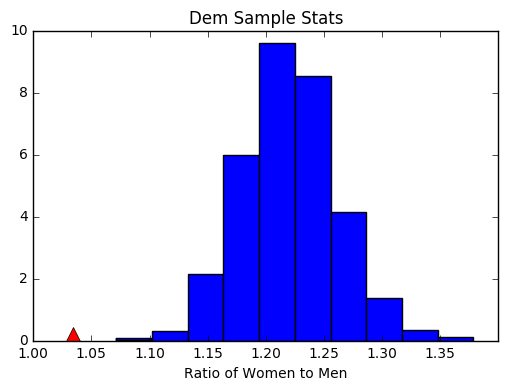

In [21]:
#dems
dem_stats = []
rep_stats = []
for _ in np.arange(1000):
    dem_m = sum(dem_sample_tbl['pop'].sample(n = total_dem, replace = True) == 'M')
    dem_f = total_dem - dem_m
    dem_stat = dem_f/dem_m
    dem_stats.append(dem_stat)

plt.hist(dem_stats, normed = True)
plt.plot(dem_pop_stat, 0.2, marker='^', markersize=10, color='red')
plt.xlabel('Ratio of Women to Men')
plt.title('Dem Sample Stats');

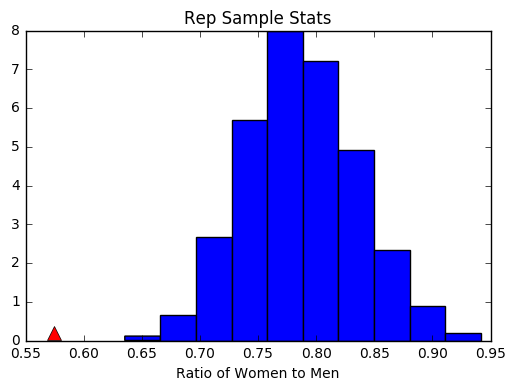

In [23]:
#gop
for _ in np.arange(1000) :   
    rep_m = sum(rep_sample_tbl['pop'].sample(n = total_rep, replace = True) == 'M')
    rep_f = total_rep - rep_m
    rep_stat = rep_f/rep_m
    rep_stats.append(rep_stat)
    
plt.hist(rep_stats, normed = True)
plt.plot(rep_pop_stat, 0.2, marker='^', markersize=10, color='red')
plt.xlabel('Ratio of Women to Men')
plt.title('Rep Sample Stats'); 

In [33]:
dem_p_val = sum(dem_stats <= dem_pop_stat)/len(dem_stats)
rep_p_val = sum(rep_stats <= rep_pop_stat)/len(rep_stats)
print('Dem p-value: %d' % (dem_p_val))
print('Rep p-value: %d' % (rep_p_val))
print('P-value less than 0.05 for both so we reject the null. That is, the ratio of female to male') 
print('appointees is more skewed in favor of men than can be explained by random chance.')

Dem p-value: 0
Rep p-value: 0
P-value less than 0.05 for both so we reject the null. That is, the ratio of female to male
appointees is more skewed in favor of men than can be explained by random chance.


In [ ]:
#frequency of press releases

In [169]:
full_tbl['temp'] = all_dates
full_tbl['month'] = full_tbl['temp'].apply(lambda x: str(x)[0:3])
full_tbl['year'] = full_tbl['temp'].apply(lambda x: str(x)[-4:])
full_tbl.drop('temp', axis = 1, inplace = True)
grouped = full_tbl.groupby(['year', 'month']).count()
#fig, ax = plt.subplots()
#grouped.rename(columns = {'release_id': 'count'}).loc[:, ['count']].plot(figsize = (8,6), use_index = True)
#plt.title('Frequency of Press Releases');

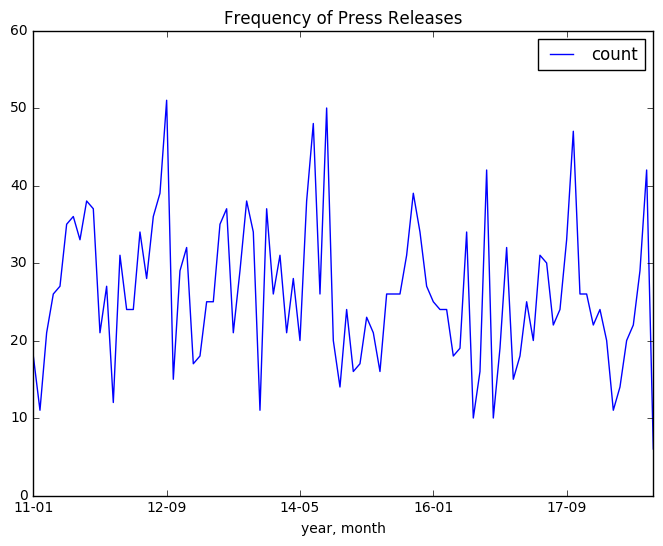

In [173]:
str(full_tbl.date.values[1])[2:7] #+ '-' + str(full_tbl.date.values[1])[2:4] 
full_tbl['year, month'] = full_tbl['date'].apply(lambda x: str(x)[2:7])
grouped = full_tbl.groupby('year, month').count().iloc[:-1].loc[:, ['release_id']].rename(columns = {'release_id':'count'})
grouped.plot(figsize = (8,6))
plt.title('Frequency of Press Releases');